In [1]:
#Import libraries & data

exec(open("../python/nb_setup.py").read())#Is there a better way to do this?

from IPython.core.display import display, HTML
from matplotlib.pyplot import *
style.use('../mplstyles/stylelib/standard.mplstyle')


from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
import pickle as pkl
import sys
sys.path.append('../python')
import R68_yield as Yield
import R68_spec_tools as spec
import R68_plot_tools as pt
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.patches as mpatches

#Set up notebook and load some R68 constants (V, eps, etc.)
from constants import *

/var/folders/vn/rb46_y0s1tl360t6yzw8bjgr0000gn/T/ipykernel_14409/495547552.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#Function Definitions

#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

In [3]:
#Now run Sorensen

model_label='Sorensen'
fnames=['data/mcmc_Sor_128walk_50kstep_SNorm_v3.pkl',
        'data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl']

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

In [4]:
#don't vectorize the function below. It already is, vectorizing will lead to bug https://github.com/numpy/numpy/issues/8758
#instead be sure to use np array only for argument!!
ySor = lambda E : Yield.ySor(E,0.151,1.96e-3) 

Et = np.asarray([33.,33,33,33,33,33,500,500,500,500,500,500,500,500,500,500.0,5000.0,500.0,500,500,500,500,500,500,500,6500.0,6500.0])
print(Et)
print(ySor(Et))

[  33.   33.   33.   33.   33.   33.  500.  500.  500.  500.  500.  500.
  500.  500.  500.  500. 5000.  500.  500.  500.  500.  500.  500.  500.
  500. 6500. 6500.]
[0.         0.         0.         0.         0.         0.
 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463
 0.03458463 0.03458463 0.03458463 0.03458463 0.25849808 0.03458463
 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463 0.03458463
 0.03458463 0.27455815 0.27455815]


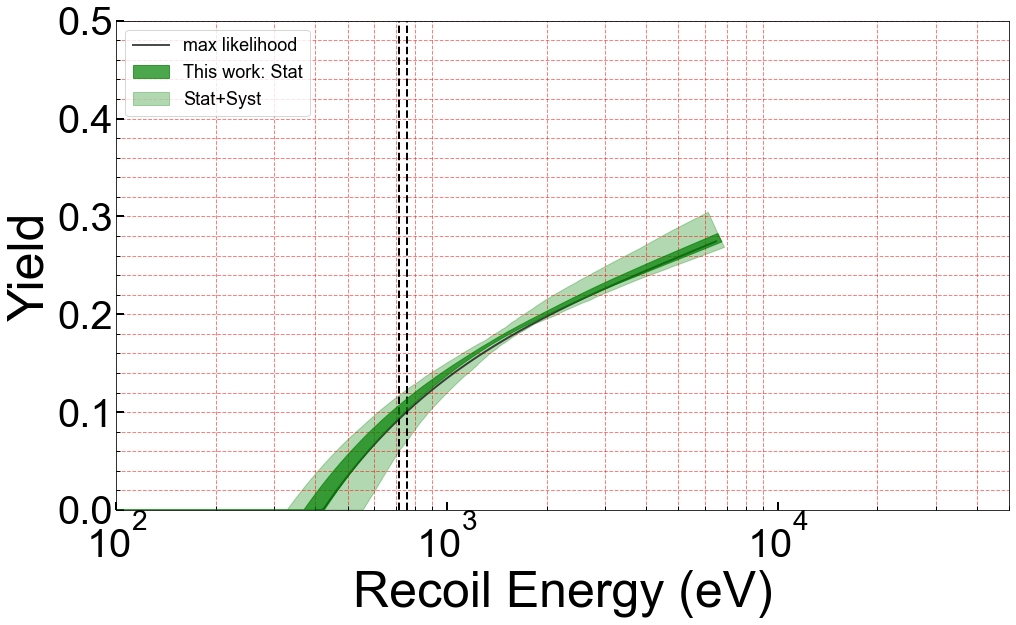

In [5]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))

plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k',linewidth=2)

plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()



In [6]:
#extract band info from file. 

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))
    
    if(i==0):
      tight_band=Er_Ycalc_plot
      ytight=Ydist_plot
      cY = ytight<0
      ytight[cY]=0
    else:
      loose_band=Er_Ycalc_plot
      yloose=Ydist_plot
      cY = yloose<0
      yloose[cY]=0


In [7]:
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [8]:
#extract the tight band energies and yields on the high and low side
#vEr is the vector of energies corresponding to those high/low yields
vEr_low=tight_band[0:1001]
vEr_high=tight_band[1001:2002]
vEl=np.zeros(np.shape(vEr_low))
vEmid=np.zeros(np.shape(vEr_low))
vEh=np.zeros(np.shape(vEr_low))
vY=np.zeros(np.shape(vEr_low))
ytight_low = ytight[0:1001]
ytight_high = ytight[1001:2002] 

#because of how the polygon is encoded vEr and ytight_high need
#to be flipped
vEr_high=np.flip(vEr_high)
ytight_high=np.flip(ytight_high)


#get the mid point yield at a particular energy
#mid = (ytight_low+ytight_high)/2.0

#calculate the highest and lowest energies that intersect the yield bands at
#a particular yield 
for i,Er_low in enumerate(vEr_low):
    vY[i] = ySor(Er_low)
    Y0,j = find_nearest(ySor(vEr_low),vY[i])
    vEmid[i] = vEr_low[j]
    #if i==612:
    #   print(vY[i])
    #   #print(ySor(vEr_low))
    #   print(vY[i],j,Er,vEr_low[j],Y0,ySor(Er))
    #print(i,vY[i])
    Y,j = find_nearest(ytight_low,vY[i])
    vEh[i] = vEr_low[j]
    #if i==612:
    #   print(j)
    Y,j = find_nearest(ytight_high,vY[i])
    #if i==612:
    #   print(j)
    vEl[i] = vEr_high[j]
    if vEh[i]<vEmid[i]:
        vEh[i] = vEmid[i]


print("{0:08.4f}\t{1:08.4f}\t{2:08.4f}".format(vEl[612],vEmid[612],vEh[612]))

706.7620	783.3008	783.3008


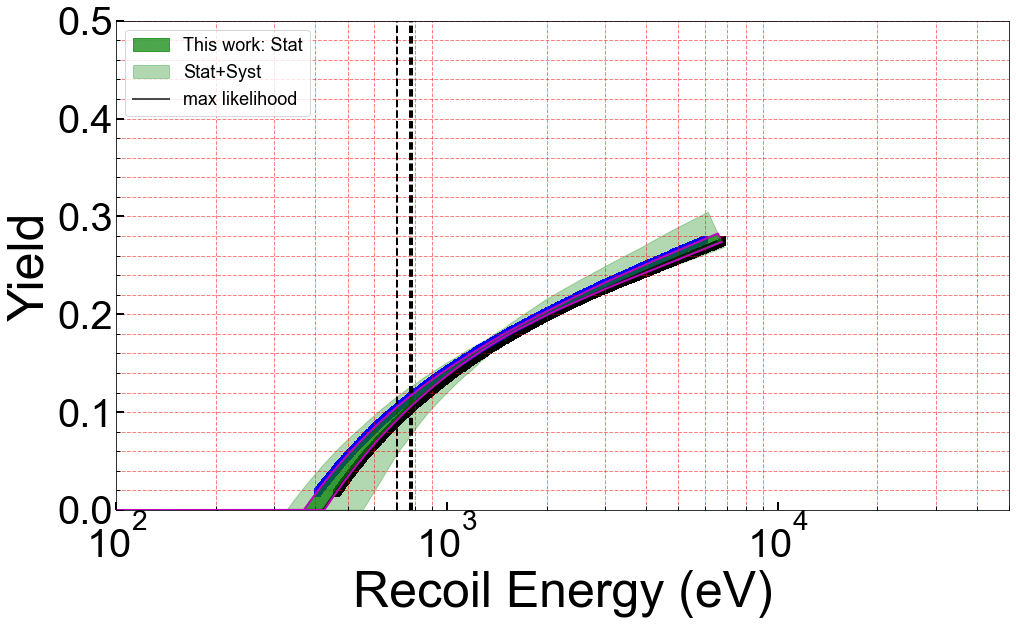

In [9]:
plt.figure(figsize=(16,9))

plot_fill_colors=['g','g']
plot_alphas=[0.7,0.3]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

vEr = np.linspace(400,6500,1000)
#print(ySor(vEr))


plt.axvline(783,color='k',linestyle="--")
plt.axvline(774,color='k',linestyle="--")
plt.axvline(706,color='k',linestyle="--")
plt.grid(color='r', linestyle='--', linewidth=1,axis="y",which="both",alpha=0.5)
plt.grid(color='r', linestyle='--', linewidth=1,axis="x",which="Minor",alpha=0.5)

for i,RQi in enumerate(RQss):
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    plt.fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])

plt.plot(vEr,ySor(vEr),label="max likelihood",alpha=0.7,color='k')
plt.plot(np.flip(tight_band[1001:2002]),ytight_high,color="m",linewidth=2)
plt.plot(tight_band[0:1001],ytight_low,color="m",linewidth=2)

plt.scatter(vEh[400:1000],vY[400:1000],color='k',marker='s')
plt.scatter(vEl[400:1000],vY[400:1000],color='b',marker='s')

plt.ylabel("Yield")
plt.xlabel("Recoil Energy (eV)")
#plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.xlim([100,50000])
plt.ylim([0,0.5])
plt.xscale('log')

plt.legend(fontsize=18,loc='upper left')
plt.show()

In [10]:
#let's do it in close to the xml format

print("\t<data-format>Mathematica</data-format>")
print("\t<data-values>")
print("\t{")

for i,Er in enumerate(vEr):
  
    print("\t{{{0:08.4f},{1:05.4f}}},".format(Er,ySor(Er)))
          
          
print("\t}")
print("\t<data-values>")

	<data-format>Mathematica</data-format>
	<data-values>
	{
	{400.0000,0.0000},
	{406.1061,0.0000},
	{412.2122,0.0000},
	{418.3183,0.0000},
	{424.4244,0.0016},
	{430.5305,0.0046},
	{436.6366,0.0076},
	{442.7427,0.0105},
	{448.8488,0.0134},
	{454.9550,0.0161},
	{461.0611,0.0188},
	{467.1672,0.0215},
	{473.2733,0.0240},
	{479.3794,0.0265},
	{485.4855,0.0290},
	{491.5916,0.0314},
	{497.6977,0.0337},
	{503.8038,0.0360},
	{509.9099,0.0382},
	{516.0160,0.0404},
	{522.1221,0.0426},
	{528.2282,0.0447},
	{534.3343,0.0467},
	{540.4404,0.0487},
	{546.5465,0.0507},
	{552.6527,0.0526},
	{558.7588,0.0545},
	{564.8649,0.0564},
	{570.9710,0.0582},
	{577.0771,0.0600},
	{583.1832,0.0617},
	{589.2893,0.0634},
	{595.3954,0.0651},
	{601.5015,0.0668},
	{607.6076,0.0684},
	{613.7137,0.0700},
	{619.8198,0.0716},
	{625.9259,0.0731},
	{632.0320,0.0746},
	{638.1381,0.0761},
	{644.2442,0.0776},
	{650.3504,0.0790},
	{656.4565,0.0804},
	{662.5626,0.0818},
	{668.6687,0.0832},
	{674.7748,0.0845},
	{680.8809,0.0859},
	{